## Set up
Import all required libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import gc
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score, 
                             accuracy_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, average_precision_score)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [2]:
# Set random seeds
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

## Data
Load and preprocess data

In [3]:
# Set image and metadata paths
img_dir = "/kaggle/input/covid-audio-data/augmented_melspectograms/melspectograms/"
label_df = pd.read_csv("/kaggle/input/covid-audio-data/labels.csv")

train_df, test_df = train_test_split(label_df, 
                                     test_size=0.2, 
                                     stratify=label_df["label"], 
                                     random_state=42)
train_df, val_df = train_test_split(train_df, 
                                     test_size=0.1, 
                                     stratify=train_df["label"], 
                                     random_state=42)

# PyTorch Dataset for loading melspectrogram images and their corresponding labels
class MelSpectrogramDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx]["label"]
        filename = self.df.iloc[idx]["filename"]

        # Read image
        img_path = os.path.join(self.img_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype(np.float32) / 255.0
        img = img.transpose(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [4]:
# Set up data loaders
BATCH_SIZE = 64

train_dataset = MelSpectrogramDataset(train_df, img_dir)
val_dataset = MelSpectrogramDataset(val_df, img_dir)
test_dataset = MelSpectrogramDataset(test_df, img_dir)

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=2, 
                          pin_memory=True, 
                          drop_last=True)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=2, 
                         pin_memory=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=2, 
                        pin_memory=True)

# Clear unused memory
gc.collect()
torch.cuda.empty_cache()

## Model
Build and train model

In [5]:
class CNN_LSTM(nn.Module):
    def __init__(self, cnn_input_channels,
                 lstm_hidden_size=128,
                 lstm_layers=2,
                 num_classes=1):
        super().__init__()

        # CNN
        self.layer1 = nn.Sequential(
            nn.Conv2d(cnn_input_channels, 16, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(16), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

        self.cnn = nn.Sequential(self.layer1, self.layer2, self.layer3)

        # LSTM
        self._lstm_built = False
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layers = lstm_layers

        # Classifier
        self.classifier = nn.Sequential(
            nn.Tanh(),
            nn.BatchNorm1d(lstm_hidden_size * 2),
            nn.Dropout(0.2),
            nn.Linear(lstm_hidden_size * 2 , 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, num_classes)
        )

    # Lazily initializes the LSTM once the input feature dimension (H * C) is known from the CNN output
    def _build_lstm(self, feat_dim):
        self.lstm = nn.LSTM(
            input_size=feat_dim,
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
            bidirectional=True,
        ).to(next(self.parameters()).device)
        self._lstm_built = True

    # Forward pass through CNN and LSTM with reshpaing
    def forward(self, x): 
        feat = self.cnn(x)
        N, C, H, W = feat.shape
        feat = feat.permute(0, 3, 2, 1)
        lstm_in = feat.reshape(N, W, H * C)

        if not self._lstm_built:
            self._build_lstm(H * C)

        lstm_out, _ = self.lstm(lstm_in)
        last_t = lstm_out[:, -1, :]
        return self.classifier(last_t)

In [6]:
# Run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)

# Initialize model
cnn_lstm = CNN_LSTM(cnn_input_channels=3).to(device)

# Enable multi-GPU training if more than one GPU is available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    cnn_lstm = nn.DataParallel(cnn_lstm)

# Loss, optimizer, scheduler
criterion_cnn_lstm = nn.BCEWithLogitsLoss()
optimizer_cnn_lstm = torch.optim.Adam(cnn_lstm.parameters(),
                             lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_cnn_lstm,
    T_0=10, # Number of epochs before first restart
    T_mult=2, # After each restart, increase cycle length
    eta_min=1e-5) # Minimum learning rate

Running on cuda


In [7]:
# Metrics to keep track of, early stopping parameters
train_accuracies = []
val_accuracies = []
train_loss=[]
val_loss=[]
best_auc = 0.0
epochs_no_improve = 0
EPOCHS = 100
patience = 10
early_stop = False

cnn_lstm.train()

for e in tqdm(range(1, EPOCHS+1)):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1)

        optimizer_cnn_lstm.zero_grad() # Reset gradients

        y_pred_logits = cnn_lstm(X_batch).view(-1) # Forward pass
        y_pred_proba = torch.sigmoid(y_pred_logits) # Convert logits to probabilities
        label_predicted = (y_pred_proba >= 0.5).int() # Binary prediction

        loss = criterion_cnn_lstm(y_pred_logits, y_batch.float()) # Compute loss
        running_loss += loss.item()

        total += y_batch.size(0)
        correct += (label_predicted == y_batch.int()).sum().item() # Count correct predictions

        loss.backward() # Backpropagation
        optimizer_cnn_lstm.step() # Update weights

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_loss.append(running_loss/len(train_loader))

    # Validation
    cnn_lstm.eval()  # Eval mode - no dropout or gradients
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    all_val_probs = []
    all_val_labels = []
    
    with torch.no_grad(): # No gradient calculation
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1)

            y_pred_logits = cnn_lstm(X_batch).view(-1) # Forward pass
            y_pred_proba = torch.sigmoid(y_pred_logits) # Convert logits to probabilities
            val_predicted = (y_pred_proba >= 0.5).int() # Binary prediction

            # For AUC calculations
            all_val_probs.extend(y_pred_proba.cpu().numpy())
            all_val_labels.extend(y_batch.cpu().numpy())

            loss = criterion_cnn_lstm(y_pred_logits, y_batch.float()) # Compute loss
            val_running_loss += loss.item()

            val_total += y_batch.size(0)
            val_correct += (val_predicted == y_batch.int()).sum().item() # Count correct predictions

    # Calulate AUC for model saving
    val_auc = roc_auc_score(all_val_labels, all_val_probs)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_loss.append(val_running_loss/len(val_loader))

    # Early stopping and save model with best AUC
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(cnn_lstm.state_dict(), '/kaggle/working/best_cnn_lstm.pth')
        print(f"Best model saved at epoch {e} with AUC = {best_auc:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {e}")
            early_stop = True

    if early_stop:
        break

    cnn_lstm.train() # Back to train mode

    # Print metrics for current model
    print(f'Epoch {e+0:03}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {train_acc:.3f} | Validation Accuracy: {val_acc:.3f}')
    scheduler.step() # Update learning rate

  1%|          | 1/100 [02:53<4:46:41, 173.76s/it]

Best model saved at epoch 1 with AUC = 0.6051
Epoch 001: | Loss: 0.69565 | Acc: 0.526 | Validation Accuracy: 0.587


  2%|▏         | 2/100 [04:26<3:26:05, 126.18s/it]

Best model saved at epoch 2 with AUC = 0.7011
Epoch 002: | Loss: 0.66031 | Acc: 0.604 | Validation Accuracy: 0.659


  3%|▎         | 3/100 [06:04<3:03:08, 113.28s/it]

Best model saved at epoch 3 with AUC = 0.7076
Epoch 003: | Loss: 0.59365 | Acc: 0.651 | Validation Accuracy: 0.666


  4%|▍         | 4/100 [07:44<2:52:49, 108.02s/it]

Best model saved at epoch 4 with AUC = 0.7597
Epoch 004: | Loss: 0.57434 | Acc: 0.671 | Validation Accuracy: 0.717


  5%|▌         | 5/100 [09:24<2:46:28, 105.15s/it]

Best model saved at epoch 5 with AUC = 0.7764
Epoch 005: | Loss: 0.53990 | Acc: 0.712 | Validation Accuracy: 0.738


  6%|▌         | 6/100 [11:03<2:41:24, 103.03s/it]

Best model saved at epoch 6 with AUC = 0.7829
Epoch 006: | Loss: 0.51628 | Acc: 0.725 | Validation Accuracy: 0.743


  7%|▋         | 7/100 [12:40<2:36:41, 101.09s/it]

Best model saved at epoch 7 with AUC = 0.7846
Epoch 007: | Loss: 0.50428 | Acc: 0.734 | Validation Accuracy: 0.743


  8%|▊         | 8/100 [14:15<2:31:59, 99.13s/it] 

Best model saved at epoch 8 with AUC = 0.7858
Epoch 008: | Loss: 0.49635 | Acc: 0.737 | Validation Accuracy: 0.745


  9%|▉         | 9/100 [15:54<2:30:07, 98.98s/it]

Epoch 009: | Loss: 0.49275 | Acc: 0.739 | Validation Accuracy: 0.746


 10%|█         | 10/100 [17:26<2:25:24, 96.94s/it]

Best model saved at epoch 10 with AUC = 0.7862
Epoch 010: | Loss: 0.49046 | Acc: 0.740 | Validation Accuracy: 0.745


 11%|█         | 11/100 [19:08<2:25:54, 98.37s/it]

Epoch 011: | Loss: 0.50695 | Acc: 0.730 | Validation Accuracy: 0.744


 12%|█▏        | 12/100 [20:55<2:28:12, 101.05s/it]

Epoch 012: | Loss: 0.49549 | Acc: 0.738 | Validation Accuracy: 0.740


 13%|█▎        | 13/100 [22:34<2:25:33, 100.38s/it]

Epoch 013: | Loss: 0.49492 | Acc: 0.737 | Validation Accuracy: 0.744


 14%|█▍        | 14/100 [24:15<2:24:27, 100.78s/it]

Epoch 014: | Loss: 0.48937 | Acc: 0.740 | Validation Accuracy: 0.743


 15%|█▌        | 15/100 [25:53<2:21:15, 99.72s/it] 

Epoch 015: | Loss: 0.48923 | Acc: 0.740 | Validation Accuracy: 0.747


 16%|█▌        | 16/100 [27:30<2:18:32, 98.96s/it]

Best model saved at epoch 16 with AUC = 0.7900
Epoch 016: | Loss: 0.48497 | Acc: 0.742 | Validation Accuracy: 0.747


 17%|█▋        | 17/100 [29:07<2:16:05, 98.38s/it]

Best model saved at epoch 17 with AUC = 0.7902
Epoch 017: | Loss: 0.48401 | Acc: 0.742 | Validation Accuracy: 0.746


 18%|█▊        | 18/100 [30:49<2:16:06, 99.59s/it]

Epoch 018: | Loss: 0.48638 | Acc: 0.742 | Validation Accuracy: 0.746


 19%|█▉        | 19/100 [32:27<2:13:50, 99.14s/it]

Epoch 019: | Loss: 0.48105 | Acc: 0.744 | Validation Accuracy: 0.747


 20%|██        | 20/100 [34:03<2:10:52, 98.16s/it]

Epoch 020: | Loss: 0.48083 | Acc: 0.744 | Validation Accuracy: 0.745


 21%|██        | 21/100 [35:41<2:08:57, 97.94s/it]

Best model saved at epoch 21 with AUC = 0.7969
Epoch 021: | Loss: 0.47845 | Acc: 0.744 | Validation Accuracy: 0.747


 22%|██▏       | 22/100 [37:12<2:04:50, 96.03s/it]

Epoch 022: | Loss: 0.47934 | Acc: 0.744 | Validation Accuracy: 0.747


 23%|██▎       | 23/100 [38:47<2:02:52, 95.74s/it]

Best model saved at epoch 23 with AUC = 0.7977
Epoch 023: | Loss: 0.47696 | Acc: 0.745 | Validation Accuracy: 0.745


 24%|██▍       | 24/100 [40:26<2:02:33, 96.75s/it]

Epoch 024: | Loss: 0.47608 | Acc: 0.745 | Validation Accuracy: 0.747


 25%|██▌       | 25/100 [42:04<2:01:16, 97.02s/it]

Epoch 025: | Loss: 0.47520 | Acc: 0.746 | Validation Accuracy: 0.747


 26%|██▌       | 26/100 [43:53<2:04:03, 100.59s/it]

Epoch 026: | Loss: 0.47618 | Acc: 0.745 | Validation Accuracy: 0.748


 27%|██▋       | 27/100 [45:31<2:01:22, 99.76s/it] 

Epoch 027: | Loss: 0.47286 | Acc: 0.746 | Validation Accuracy: 0.747


 28%|██▊       | 28/100 [47:02<1:56:43, 97.28s/it]

Best model saved at epoch 28 with AUC = 0.7979
Epoch 028: | Loss: 0.47493 | Acc: 0.745 | Validation Accuracy: 0.746


 29%|██▉       | 29/100 [48:41<1:55:39, 97.74s/it]

Epoch 029: | Loss: 0.47293 | Acc: 0.746 | Validation Accuracy: 0.747


 30%|███       | 30/100 [50:17<1:53:28, 97.27s/it]

Epoch 030: | Loss: 0.47349 | Acc: 0.746 | Validation Accuracy: 0.747


 31%|███       | 31/100 [51:47<1:49:24, 95.14s/it]

Epoch 031: | Loss: 0.48636 | Acc: 0.741 | Validation Accuracy: 0.747


 32%|███▏      | 32/100 [53:28<1:49:47, 96.87s/it]

Epoch 032: | Loss: 0.48442 | Acc: 0.743 | Validation Accuracy: 0.746


 33%|███▎      | 33/100 [55:05<1:47:57, 96.67s/it]

Epoch 033: | Loss: 0.48319 | Acc: 0.743 | Validation Accuracy: 0.747


 34%|███▍      | 34/100 [56:43<1:46:51, 97.14s/it]

Epoch 034: | Loss: 0.48195 | Acc: 0.744 | Validation Accuracy: 0.745


 35%|███▌      | 35/100 [58:17<1:44:13, 96.21s/it]

Epoch 035: | Loss: 0.47928 | Acc: 0.745 | Validation Accuracy: 0.747


 36%|███▌      | 36/100 [59:51<1:42:03, 95.68s/it]

Epoch 036: | Loss: 0.47963 | Acc: 0.744 | Validation Accuracy: 0.746


 37%|███▋      | 37/100 [1:01:30<1:41:33, 96.72s/it]

Epoch 037: | Loss: 0.47948 | Acc: 0.744 | Validation Accuracy: 0.746


 38%|███▊      | 38/100 [1:03:05<1:39:09, 95.96s/it]

Best model saved at epoch 38 with AUC = 0.7999
Epoch 038: | Loss: 0.47803 | Acc: 0.745 | Validation Accuracy: 0.741


 39%|███▉      | 39/100 [1:04:40<1:37:19, 95.72s/it]

Epoch 039: | Loss: 0.47852 | Acc: 0.744 | Validation Accuracy: 0.747


 40%|████      | 40/100 [1:06:16<1:35:50, 95.84s/it]

Best model saved at epoch 40 with AUC = 0.8018
Epoch 040: | Loss: 0.47649 | Acc: 0.745 | Validation Accuracy: 0.747


 41%|████      | 41/100 [1:07:55<1:35:03, 96.68s/it]

Epoch 041: | Loss: 0.47687 | Acc: 0.745 | Validation Accuracy: 0.747


 42%|████▏     | 42/100 [1:09:34<1:34:18, 97.55s/it]

Epoch 042: | Loss: 0.47631 | Acc: 0.745 | Validation Accuracy: 0.748


 43%|████▎     | 43/100 [1:11:12<1:32:40, 97.56s/it]

Best model saved at epoch 43 with AUC = 0.8027
Epoch 043: | Loss: 0.47500 | Acc: 0.745 | Validation Accuracy: 0.748


 44%|████▍     | 44/100 [1:12:49<1:31:04, 97.58s/it]

Epoch 044: | Loss: 0.47453 | Acc: 0.744 | Validation Accuracy: 0.747


 45%|████▌     | 45/100 [1:14:21<1:27:49, 95.80s/it]

Epoch 045: | Loss: 0.47410 | Acc: 0.745 | Validation Accuracy: 0.746


 46%|████▌     | 46/100 [1:16:01<1:27:19, 97.03s/it]

Epoch 046: | Loss: 0.47334 | Acc: 0.745 | Validation Accuracy: 0.747


 47%|████▋     | 47/100 [1:17:40<1:26:08, 97.51s/it]

Epoch 047: | Loss: 0.47567 | Acc: 0.744 | Validation Accuracy: 0.747


 48%|████▊     | 48/100 [1:19:17<1:24:37, 97.65s/it]

Epoch 048: | Loss: 0.47338 | Acc: 0.745 | Validation Accuracy: 0.747


 49%|████▉     | 49/100 [1:20:53<1:22:31, 97.10s/it]

Epoch 049: | Loss: 0.47354 | Acc: 0.745 | Validation Accuracy: 0.747


 50%|█████     | 50/100 [1:22:28<1:20:19, 96.40s/it]

Epoch 050: | Loss: 0.47564 | Acc: 0.744 | Validation Accuracy: 0.748


 51%|█████     | 51/100 [1:24:04<1:18:41, 96.35s/it]

Epoch 051: | Loss: 0.47216 | Acc: 0.746 | Validation Accuracy: 0.747


 52%|█████▏    | 52/100 [1:25:41<1:17:08, 96.43s/it]

Epoch 052: | Loss: 0.47162 | Acc: 0.746 | Validation Accuracy: 0.746


 52%|█████▏    | 52/100 [1:27:18<1:20:35, 100.74s/it]

Early stopping triggered at epoch 53


In [8]:
# Save final model
torch.save(cnn_lstm.state_dict(), "/kaggle/working/final_cnn_lstm.pth")

In [9]:
def plot_train_val_accuracy(train_accuracies,val_accuracies, title='Training and Validation Accuracy', y_lims=[0, 1]):
    """
    Plots training and validation accuracy over epochs
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend()
    plt.grid()
    plt.savefig('/kaggle/working/accuracy.png')
    plt.show()

def plot_train_val_loss(train_loss,val_loss, title='Training and Validation Loss'):
    """
    Plots training and validation loss over epochs
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='blue', marker='o')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='red', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig('/kaggle/working/loss.png')

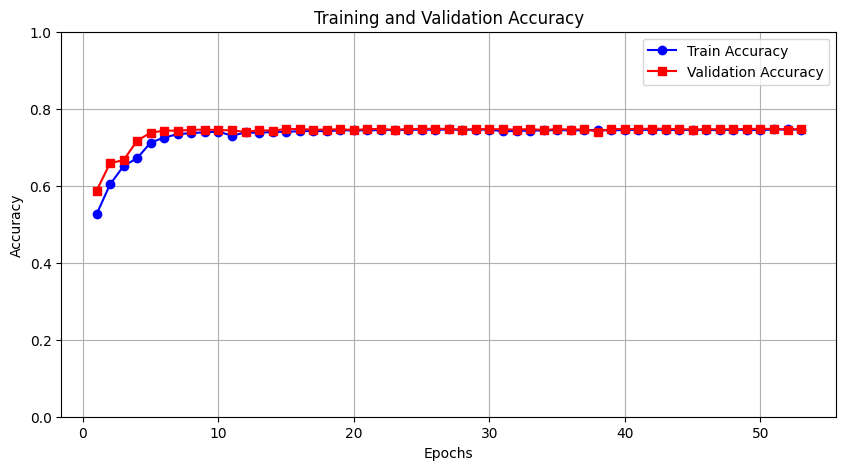

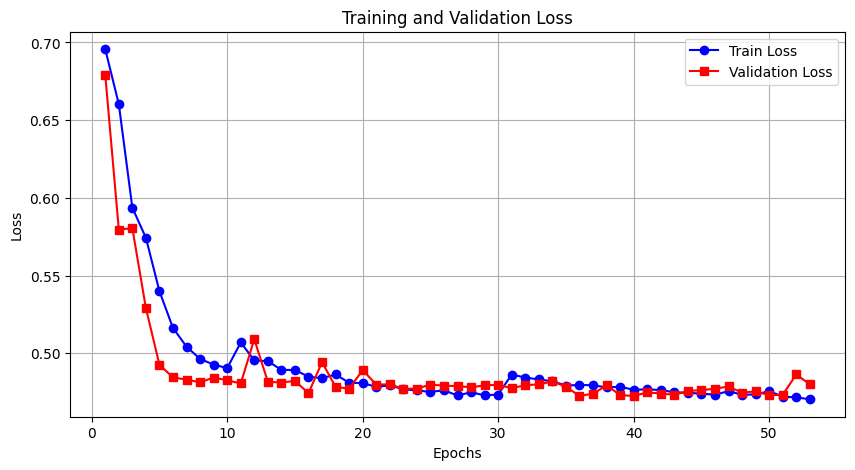

In [10]:
# Plot accuracy and loss curves
plot_train_val_accuracy(train_accuracies, val_accuracies)
plot_train_val_loss(train_loss, val_loss)

## Test data
Run model on the test data and view results

In [11]:
# Run model on test data and keep track of metrics
cnn_lstm.load_state_dict(torch.load('/kaggle/working/best_cnn_lstm.pth'))
cnn_lstm.eval()
correct = 0
total = 0
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad(): # No gradient calculation
    for X_batch, y_batch in test_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1) 
        
        output = cnn_lstm(X_batch).view(-1) # Forward pass
        probs = torch.sigmoid(output) # Convert logits to probabilities
        preds = (probs >= 0.5).float() # Binary prediction

        # Keep track of metrics
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
        
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

/tmp/ipykernel_19/1032229002.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_lstm.load_state_dict(torch.load('/kaggle/working/best_cnn_lstm.pth'))


In [12]:
# Convert result lists to arrays
y_test = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

# Save arrays
np.save('/kaggle/working/y_test_tuned.npy', y_test)
np.save('/kaggle/working/y_pred_tuned.npy', y_pred)
np.save('/kaggle/working/y_prob_tuned.npy', y_prob)

In [13]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Healthy', 'Actually COVID'],
                            columns = ['Predicted Healthy', 'Predicted COVID'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
                  Predicted Healthy  Predicted COVID
Actually Healthy               3400                1
Actually COVID                 1669             1750

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      1.00      0.80      3401
         1.0       1.00      0.51      0.68      3419

    accuracy                           0.76      6820
   macro avg       0.84      0.76      0.74      6820
weighted avg       0.84      0.76      0.74      6820



In [14]:
# Compute and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Accuracy: 0.7551
Precision: 0.9994
Recall: 0.511846
F1-Score: 0.6770
AUC: 0.8133


In [15]:
def plot_roc_curve(fpr, tpr):
    """
    Plot ROC curve
    """
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})", color='blue', linewidth=2)
    plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig('/kaggle/working/roc.png')
    plt.show()

def pr_and_f1_curves(y_true, y_prob):
    """
    Plot precision-recall curve and F1 vs threshold curve
    """
    prec, rec, thresh = precision_recall_curve(y_true, y_prob)
    prec, rec = prec[:-1], rec[:-1]
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

    best_idx      = np.argmax(f1)
    best_thr      = thresh[best_idx]
    best_f1       = f1[best_idx]
    avg_prec      = average_precision_score(y_true, y_prob)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

    # Left: PR curve
    ax[0].plot(rec, prec, color='blue', label=f'PR curve  (AP = {avg_prec:.3f})')
    ax[0].scatter(rec[best_idx], prec[best_idx], color='red', zorder=5,
                  label=f'Best F₁ = {best_f1:.3f}\n@ thr = {best_thr:.2f}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision–Recall curve')
    ax[0].legend()
    ax[0].grid(True)

    # Right: F1 vs threshold
    ax[1].plot(thresh, f1, color='blue')
    ax[1].scatter(best_thr, best_f1, color='red', zorder=5)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('F₁ score')
    ax[1].set_title('F₁ score vs decision threshold')
    ax[1].grid(True)

    plt.tight_layout()
    plt.savefig('/kaggle/working/pr_f1.png')
    plt.show()

    return best_thr, best_f1

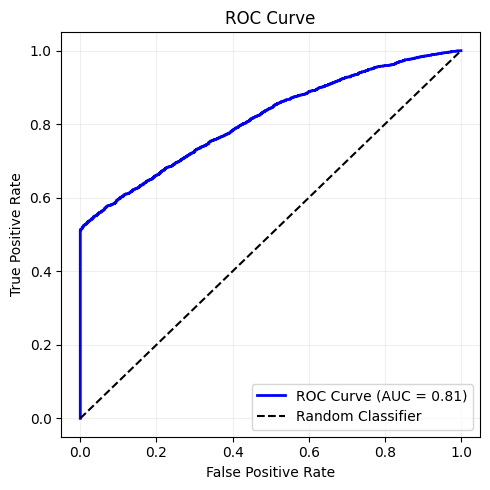

In [16]:
# ROC curve
plot_roc_curve(fpr, tpr)

## Maximizing F1 score
Inspect the precision-recall curve and F1 vs threshold score, and change threshold to maximize F1 score

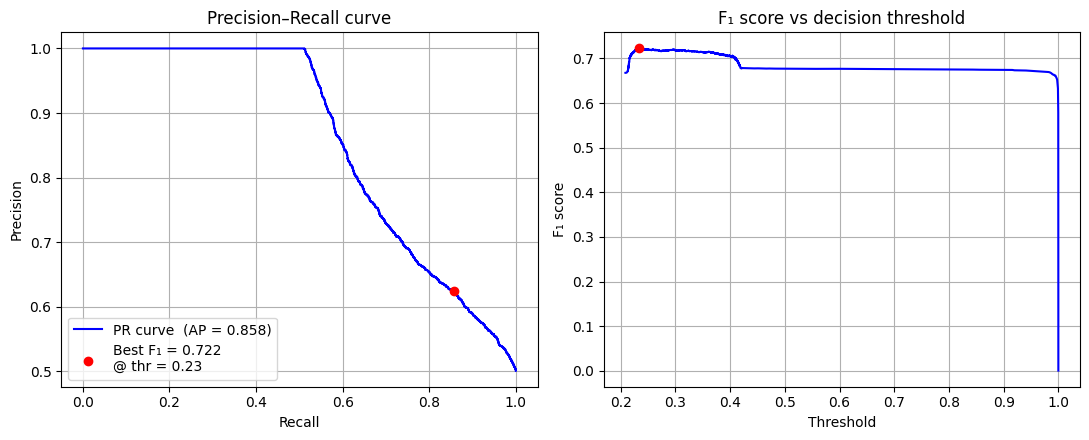

Optimal threshold = 0.233  |  Best F1 = 0.722


In [17]:
# Plot precision-recall and F1 vs threshold plots
best_thr, best_f1 = pr_and_f1_curves(all_labels, all_probs)
print(f"Optimal threshold = {best_thr:.3f}  |  Best F1 = {best_f1:.3f}")

In [18]:
# Change threshold to maximise F1 score
final_preds = (np.array(all_probs) >= best_thr).astype(int)

In [19]:
# New confusion matrix
cm = confusion_matrix(y_test, final_preds)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Healthy', 'Actually COVID'],
                            columns = ['Predicted Healthy', 'Predicted COVID'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# New classification report
print("Classification Report:")
print(classification_report(y_test, final_preds, zero_division=0))

Confusion Matrix:
                  Predicted Healthy  Predicted COVID
Actually Healthy               1639             1762
Actually COVID                  489             2930

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.48      0.59      3401
         1.0       0.62      0.86      0.72      3419

    accuracy                           0.67      6820
   macro avg       0.70      0.67      0.66      6820
weighted avg       0.70      0.67      0.66      6820



In [20]:
# Recompute and print metrics
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds, zero_division=0)
recall = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Accuracy: 0.6699
Precision: 0.6245
Recall: 0.856976
F1-Score: 0.7225
AUC: 0.8133
